In [1]:
import cv2
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10, CIFAR10

# Preprocess STL10 images by converting them from RGB to LAB
class RGB2LabTransform:
    def __call__(self, image):
        # Convert PyTorch tensor (C x H x W) to NumPy array (H x W x C)
        np_image = image.numpy().transpose(1, 2, 0)
        
        # Convert RGB to LAB using OpenCV
        lab_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2LAB)
        
        # Extract L channel and AB channels
        L_channel = lab_image[:, :, 0] / 255.0  # Normalize L channel to [0, 1]
        AB_channels = (lab_image[:, :, 1:] + 128) / 255.0  # Normalize AB channels to [0, 1]
        
        # Convert L and AB channels back to PyTorch tensors
        L_tensor = torch.tensor(L_channel).unsqueeze(0)  # Add channel dimension for L
        AB_tensor = torch.tensor(AB_channels).permute(2, 0, 1)  # Permute AB channels to (C, H, W)
        
        return L_tensor, AB_tensor


class CIFAR10ColorizationDataset(CIFAR10):
    def __getitem__(self, index):
        # Get the original image from the parent class
        image, _ = super().__getitem__(index)
        
        # Apply the LAB transformation to the image
        L_channel, AB_channels = RGB2LabTransform()(image)
        
        return L_channel, AB_channels

# Define transformations for STL10 dataset (no need to apply RGB2Lab in transform)
transform = transforms.Compose([
    transforms.ToTensor()        # Convert PIL Image to tensor
])


In [17]:
# Load CIFAR10 dataset
cifar10_pretrain = CIFAR10ColorizationDataset(root='../data', train=True, download=True, transform=transform)

# DataLoader to feed batches for training
pretrain_loader = DataLoader(cifar10_pretrain, batch_size=64, shuffle=True)

# Example to test if the loader works as expected
for L_channel, AB_channels in pretrain_loader:
    print(f"L_channel shape: {L_channel.shape}, AB_channels shape: {AB_channels.shape}")
    break  # Just checking one batch

Files already downloaded and verified
L_channel shape: torch.Size([64, 1, 32, 32]), AB_channels shape: torch.Size([64, 2, 32, 32])


In [25]:
import torch.nn as nn
import torch

class Colorization(nn.Module):
    def __init__(self, backbone):
        super(Colorization, self).__init__()
        self.backbone = backbone

        self.colorization_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.Tanh()  # Output should be in range [-1, 1]
        )
        
        # Upsampling to 96x96
        self.upsample = nn.Upsample(size=(32, 32), mode='bilinear', align_corners=False)
        
    def forward(self, L_channel):
        features = self.backbone(L_channel)

        AB_channels = self.colorization_head(features)
        AB_channels = self.upsample(AB_channels)
        return AB_channels
    

In [26]:
from torchvision.models import resnet18

backbone = resnet18(weights=None)
backbone = nn.Sequential(*list(backbone.children())[:-2])

colorization_model = Colorization(backbone)

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU
    print('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # Use Apple's Metal (for M1/M2 Macs)
    print('mps')
else:
    device = torch.device("cpu") 
    print('cpu')

mps


In [28]:
colorization_model = colorization_model.to(device)

In [29]:
class EarlyStopping:
    def __init__(self, paitence=15, min_delta=0):
        self.paitence = paitence
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.paitence:
                self.early_stop = True

In [30]:
# Training loop
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(colorization_model.parameters(), lr=1e-3)

early_stop = EarlyStopping(paitence=15,min_delta=0.000001)


for epoch in range(num_epochs):
    total_loss = 0.0  # Initialize total loss for this epoch
    num_batches = 0   # Keep track of the number of batches

    # Training loop for the current epoch
    for L_channel, AB_channels in pretrain_loader:
        # Move data to the same device as the model
        L_channel = L_channel.to(device)
        AB_channels = AB_channels.to(device)
        
        L_channel_rgb = L_channel.repeat(1, 3, 1, 1)  # Shape: [batch_size, 3, 96, 96]

        # Forward pass
        predicted_AB = colorization_model(L_channel_rgb)

        # Compute loss
        # print(predicted_AB.shape)
        # print(AB_channels.shape)
        loss = criterion(predicted_AB, AB_channels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and count batches
        total_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    average_loss = total_loss / num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}')

    early_stop(average_loss)


    # print(early_stop.counter)
    if early_stop.early_stop:
        print("Early Stopping Triggered. No improves in Loss for the last 10 epochs")
        break
    
    if (epoch + 1) % 10 == 0:
        torch.save(colorization_model.state_dict(), f'models/colorization_model_weights_cifar_epoch_{epoch+1}.pth')

    if average_loss < early_stop.best_loss:
        best_model_weights = colorization_model.state_dict()

torch.save(colorization_model.state_dict(), 'models/colorization_model_weights_cifar_final.pth')
torch.save(best_model_weights, 'models/colorization_best_model_weights_cifar_final.pth')


torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 32, 32])
torch.Size([64, 2, 3

KeyboardInterrupt: 

In [25]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt

def visualize_colorization(L_channel, predicted_AB, ground_truth_AB):
    batch_size = L_channel.shape[0]

    for i in range(batch_size):
        # Convert model's output (predicted_AB) to RGB for each sample in the batch
        colorized_image = lab_to_rgb(L_channel[i], predicted_AB[i])

        # Convert the ground truth to RGB for each sample
        ground_truth_rgb = lab_to_rgb(L_channel[i], ground_truth_AB[i])

        # Display the colorized image and the ground truth (visualization code)
        plt.subplot(1, 2, 1)
        plt.imshow(colorized_image)
        plt.title('Predicted Colorization')

        plt.subplot(1, 2, 2)
        plt.imshow(ground_truth_rgb)
        plt.title('Ground Truth')

        plt.show()
        print(f"Predicted AB min: {predicted_AB[i].min():.2f}, max: {predicted_AB[i].max():.2f}")
        print(f"Ground Truth AB min: {ground_truth_AB[i].min():.2f}, max: {ground_truth_AB[i].max():.2f}")

# Convert LAB to RGB
def lab_to_rgb(L_channel, AB_channels):
    # Ensure L_channel has shape [96, 96] and scale it appropriately
    L_channel = L_channel.squeeze().cpu().numpy() * 255
    L_channel = L_channel 

    # Ensure AB_channels has shape [2, 96, 96] and transpose it to [96, 96, 2]
    AB_channels = AB_channels.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    AB_channels = (AB_channels * 255) - 128

    # Concatenate L and AB channels to form LAB image
    lab_image = np.concatenate((L_channel[:, :, np.newaxis], AB_channels), axis=-1)

    # Convert LAB to RGB using a library like skimage
    rgb_image = color.lab2rgb(lab_image)
    
    return rgb_image


In [26]:
print(L_channel.shape)
print(predicted_AB.shape)
print(AB_channels.shape)


torch.Size([8, 1, 96, 96])
torch.Size([8, 2, 96, 96])
torch.Size([8, 2, 96, 96])


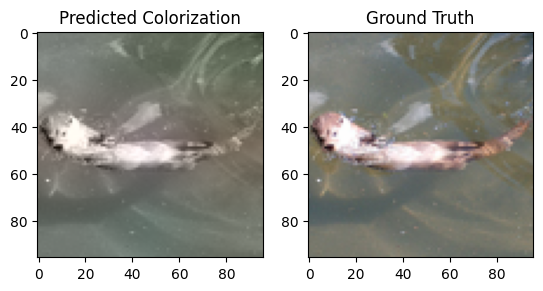

Predicted AB min: 0.47, max: 0.54
Ground Truth AB min: 0.43, max: 0.60


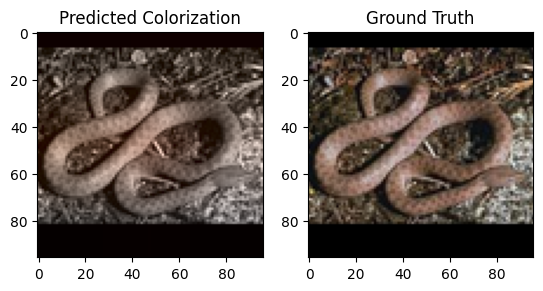

Predicted AB min: 0.51, max: 0.56
Ground Truth AB min: 0.47, max: 0.63


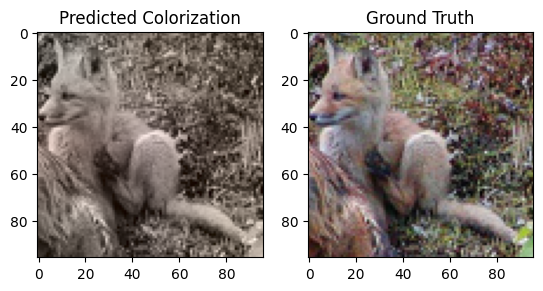

Predicted AB min: 0.51, max: 0.53
Ground Truth AB min: 0.37, max: 0.77


/var/folders/rw/35py9_rs1z90r14f5srqkfg40000gn/T/ipykernel_97964/2688519810.py:42: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


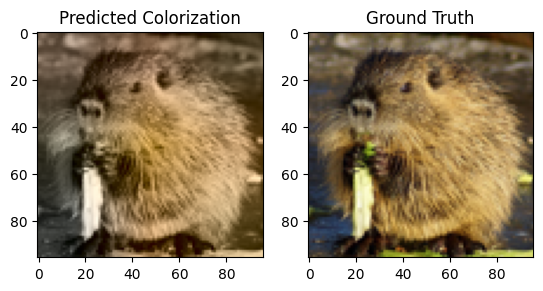

Predicted AB min: 0.50, max: 0.69
Ground Truth AB min: 0.40, max: 0.75


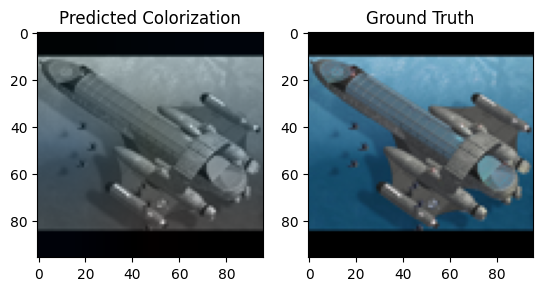

Predicted AB min: 0.45, max: 0.51
Ground Truth AB min: 0.40, max: 0.56


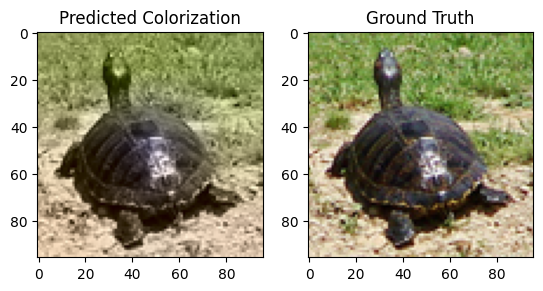

Predicted AB min: 0.44, max: 0.65
Ground Truth AB min: 0.37, max: 0.70


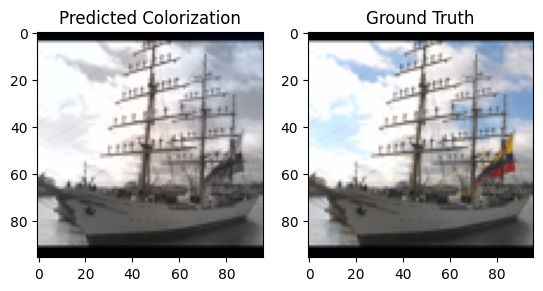

Predicted AB min: 0.46, max: 0.52
Ground Truth AB min: 0.40, max: 0.74


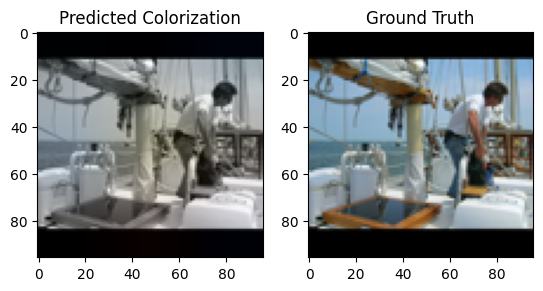

Predicted AB min: 0.47, max: 0.55
Ground Truth AB min: 0.35, max: 0.69


In [32]:
visualize_colorization(L_channel, predicted_AB, AB_channels)


## Load trained model

In [6]:
PATH = 'models/colorization_model_weights_epoch_50.pth'
state_dict = torch.load(PATH, map_location=torch.device('mps'))
colorization_model.load_state_dict(state_dict)


/var/folders/rw/35py9_rs1z90r14f5srqkfg40000gn/T/ipykernel_85288/4076605758.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(PATH, map_location=to

<All keys matched successfully>

## Downstream Classification

In [28]:
for param in colorization_model.backbone.parameters():
    param.requires_grad = False

In [35]:
class ClassificationNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(ClassificationNet, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        pooled_features = nn.AdaptiveAvgPool2d((1, 1))(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        output = self.classifier(pooled_features)
        return output

classification_model = ClassificationNet(colorization_model.backbone, num_classes=10).to(device)

In [37]:
classification_transform = transforms.Compose([
    # transforms.RandomResizedCrop(96),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # RGB for classification
])

In [38]:
stl10_train = STL10(root='./data', split='train', download=True, transform=classification_transform)
stl10_test = STL10(root='./data', split='test', download=True, transform=classification_transform)

# Fine-tuning: Load training data for classification task
train_loader = DataLoader(stl10_train, batch_size=64, shuffle=True)

# Testing: Load test data for final evaluation
test_loader = DataLoader(stl10_test, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [39]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(classification_model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 150
for epoch in range(num_epochs):
    classification_model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = classification_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        torch.save(classification_model.state_dict(), f'models/classification_model_weights_epoch_{epoch+1}.pth')



PATH = 'models/classification_model_weights_final.pth'
torch.save(classification_model.state_dict(), PATH)

Epoch [1/150], Loss: 2.2780
Epoch [2/150], Loss: 2.2272
Epoch [3/150], Loss: 2.1824
Epoch [4/150], Loss: 2.1401
Epoch [5/150], Loss: 2.1002
Epoch [6/150], Loss: 2.0623
Epoch [7/150], Loss: 2.0288
Epoch [8/150], Loss: 1.9982
Epoch [9/150], Loss: 1.9670
Epoch [10/150], Loss: 1.9367
Epoch [11/150], Loss: 1.9113
Epoch [12/150], Loss: 1.8855
Epoch [13/150], Loss: 1.8640
Epoch [14/150], Loss: 1.8407
Epoch [15/150], Loss: 1.8193
Epoch [16/150], Loss: 1.7985
Epoch [17/150], Loss: 1.7803
Epoch [18/150], Loss: 1.7611
Epoch [19/150], Loss: 1.7440
Epoch [20/150], Loss: 1.7282
Epoch [21/150], Loss: 1.7099
Epoch [22/150], Loss: 1.6939
Epoch [23/150], Loss: 1.6791
Epoch [24/150], Loss: 1.6657
Epoch [25/150], Loss: 1.6558
Epoch [26/150], Loss: 1.6394
Epoch [27/150], Loss: 1.6285
Epoch [28/150], Loss: 1.6126
Epoch [29/150], Loss: 1.6063
Epoch [30/150], Loss: 1.5945
Epoch [31/150], Loss: 1.5829
Epoch [32/150], Loss: 1.5737
Epoch [33/150], Loss: 1.5643
Epoch [34/150], Loss: 1.5579
Epoch [35/150], Loss: 1

In [40]:
# Evaluation
classification_model.eval()  # Set model to evaluation mode
correct = 0
top_5_correct = 0
top_3_correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classification_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        _, predicted_3 = torch.topk(outputs.data, k=3, dim=1)
        correct_3 = predicted_3.eq(labels.unsqueeze(1).expand_as(predicted_3))
        top_3_correct += correct_3.any(dim=1).sum().item()

        _, predicted_5 = torch.topk(outputs.data, k=5, dim=1)
        correct_5 = predicted_5.eq(labels.unsqueeze(1).expand_as(predicted_5))
        top_5_correct += correct_5.any(dim=1).sum().item()



accuracy = 100 * correct / total
top_5 = 100 * top_5_correct / total
top_3 = 100 * top_3_correct / total
print(f'Top-1 Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'Top-5 Accuracy of the model on the test set: {top_5:.2f}%')
print(f'Top-3 Accuracy of the model on the test set: {top_3:.2f}%')

Top-1 Accuracy of the model on the test set: 49.77%
Top-5 Accuracy of the model on the test set: 93.09%
Top-3 Accuracy of the model on the test set: 80.94%


In [41]:
torch.mps.empty_cache()
